In [1]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_cdf(input_path):
    df = pd.read_csv(input_path)

    if 'wind_duration_ns' not in df.columns:
        raise ValueError(
            "Input CSV must contain a 'wind_duration_ns' column"
        )

    # Convert to milliseconds
    durations_ms = df['wind_duration_ns'] / 1e6

    # Compute and print quantiles
    q_levels = [0.0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
    quantiles = np.quantile(durations_ms, q_levels, method="lower")
    print("Quantiles of window durations (ms):")
    for q, val in zip(q_levels, quantiles):
        label = f"{int(q*100)}th percentile" if q != 1.0 else "100th percentile"
        print(f"{label}: {val:.3f} ms")


    # Compute CDF
    sorted_vals = np.sort(durations_ms.values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    # plt.xscale("log")
    plt.xlabel("Window size (ms)")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0],
               ['0', '0.25', '0.5', '0.75', '1'])
    plt.tight_layout()
    plt.title('CDF of Window Sizes for Rank')

    plt.plot(sorted_vals, cdf_vals)
    # plt.savefig('rank0_windows_cdf.png')
    plt.show()

Quantiles of window durations (ms):
0th percentile: 70.547 ms
25th percentile: 85.235 ms
50th percentile: 421.955 ms
75th percentile: 1365.926 ms
90th percentile: 1386.921 ms
95th percentile: 1403.004 ms
99th percentile: 1415.883 ms
100th percentile: 1422.782 ms


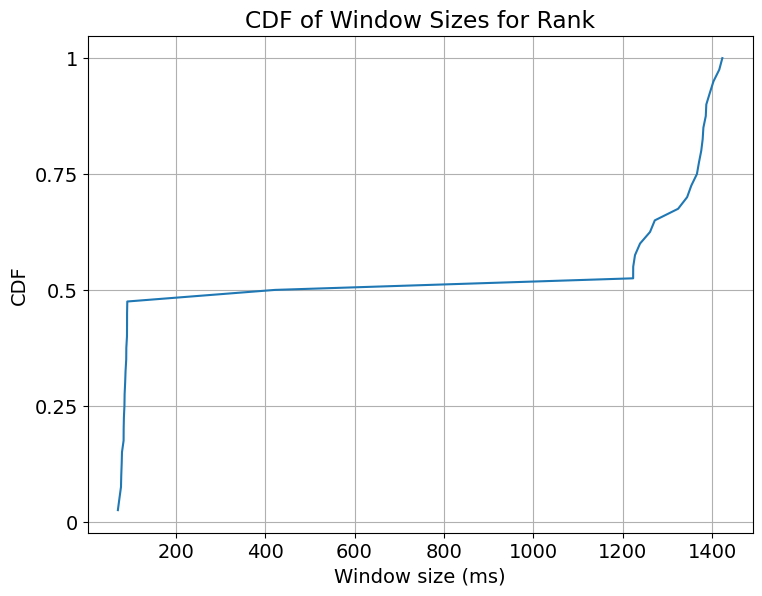

In [3]:
plot_cdf("../traces/node0_rank0_windows.csv")

In [ ]:
plot_size_to_count_window("../traces/node0_rank0_windows.csv")

Previous CDF per rank for reference:
https://github.com/chuhan-ouyang/torchtitan/blob/nsys/windows/traces-scripts/trace-events/all_ranks_dp_2_tp_4_pp_2_events_processed_window_cdf.png